#  Question: Are certain areas more prone to crime than other areas?

In [822]:
%%capture --no-display

# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import pprint
from uszipcode import SearchEngine
from config import api_key
from census import Census
import hvplot.pandas
import dataframe_image as dfi

## Data Organization

In [823]:
# Read in data from csv file
final_df = pd.read_csv("chicago_crimes_all_cleaned.csv")
final_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145665,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
1145666,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
1145667,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
1145668,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [824]:
# Get an array of all years
years = final_df["Year"].unique()

In [825]:
# Split data file into years
df_2018 = final_df[final_df["Year"]==2018]
df_2019 = final_df[final_df["Year"]==2019]
df_2020 = final_df[final_df["Year"]==2020]
df_2021 = final_df[final_df["Year"]==2021]
df_2022 = final_df[final_df["Year"]==2022]
df_2018

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
894540,JB115033,01/02/2018 11:00:00 AM,064XX W ADDISON ST,THEFT (ALL TYPES),OVER $500,16,36.0,2018,41.945654,-87.786853,"(41.945653748, -87.786852586)",24272.0,60706.0
894541,JB101356,01/02/2018 08:05:00 AM,051XX N NORMANDY AVE,ASSAULT & BATTERY,SIMPLE,16,41.0,2018,41.974559,-87.793957,"(41.974559221, -87.793956917)",24272.0,60706.0
894542,JB101127,01/01/2018 10:30:00 PM,062XX W CORNELIA AVE,OTHER MINOR CRIMES,HARASSMENT BY ELECTRONIC MEANS,16,36.0,2018,41.943873,-87.782380,"(41.943873325, -87.782379691)",24272.0,60706.0
894543,JB100762,01/01/2018 12:00:00 PM,063XX W WAVELAND AVE,OTHER MINOR CRIMES,HARASSMENT BY ELECTRONIC MEANS,16,38.0,2018,41.947501,-87.784668,"(41.947501166, -87.784667989)",24272.0,60706.0


## Perform Per Capita Calculations, Tables, and Graphs

In [826]:
# Create a data frame of population from year to year, noting that zip codes repeat, thus creating repeated population counts,
# since we pulled population based on zip code. So, we groupby unique zip code, get the population for each zip code, and sum by population,
# then by population across all zip codes for one year
population = [df_2018.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2019.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2020.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2021.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2022.groupby("Zipcode")["Population"].unique().sum().sum()]

In [827]:
# Look at types of crime per capita on the year level
# Count total crimes by crime type per year
year_crime_cnt = final_df.groupby("Year")["Primary Type"].count()
year_crime_cnt

# Get the population for each year
pop_per_year = population
pop_per_year

# Calculate per capita count
per_capita_crime_rate = year_crime_cnt/pop_per_year

# Put it in a dataframe
yearly_per_capita = pd.DataFrame({"Year" : per_capita_crime_rate.index, "Per Capita Rate" : per_capita_crime_rate.values})
yearly_per_capita

,Year,Per Capita Rate
0,2018,0.086561
1,2019,0.084422
2,2020,0.068019
3,2021,0.066141
4,2022,0.076041


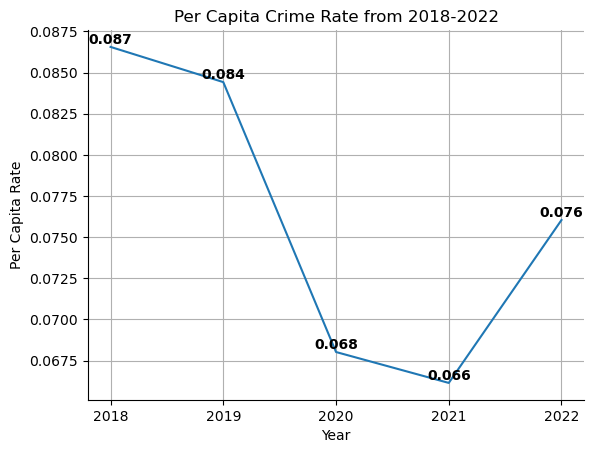

In [828]:
# Graph per capita crime rates over 2018-2022
plt.plot(yearly_per_capita["Year"], yearly_per_capita["Per Capita Rate"])

# Add labels
plt.xlabel("Year")
plt.ylabel("Per Capita Rate")
plt.title("Per Capita Crime Rate from 2018-2022")

# Add values to the line chart
for x, y in zip(yearly_per_capita["Year"], yearly_per_capita["Per Capita Rate"]):
    plt.text(x, y, f"{y:.3f}", ha="center", va="bottom", weight = "bold")

# Create new x-ticks
new_xticks = years
plt.xticks(new_xticks)

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid
plt.grid(True)

## Save the figure
plt.savefig("Images/PerCapitaCrimeRate2018_2022.png")
plt.show()

In [829]:
# Look at per capita crime rate per district over the five year timespan
# Grab selected columns we want to look at
district_df = final_df[["Year", "District", "Primary Type", "Population", "Zipcode"]]
district_df

# Get the population per district by creating a new data frame and dropping any unique combinations of distict, zip code, and population,
# since population will be duplicated multiple times when zip code is listed more than once
unique_pop = district_df[["District", "Zipcode", "Population"]].drop_duplicates()
pop_per_district = unique_pop.groupby("District")["Population"].sum()

# Get the count per district by grouping by district and counting primary type of crime
cnt_per_district = district_df.groupby("District")["Primary Type"].count()
cnt_per_district

# Get the per capita crime rate by dividing the count per district by the population per district
per_cap_crime_count = cnt_per_district/pop_per_district

# Put in a data frame for ease of use
district_per_capita = pd.DataFrame({"District" : per_cap_crime_count.index, "Per Capita Crime Rate" : per_cap_crime_count.values})

# Sort the values
district_per_capita.sort_values(by = "Per Capita Crime Rate", ascending = False, inplace=True)
district_per_capita

,District,Per Capita Crime Rate
0,1,0.097490
6,7,0.079481
16,18,0.075589
3,4,0.067163
5,6,0.066932
10,11,0.060918
1,2,0.056675
2,3,0.055896
20,24,0.053523
13,15,0.049419


<Figure size 2000x2000 with 0 Axes>

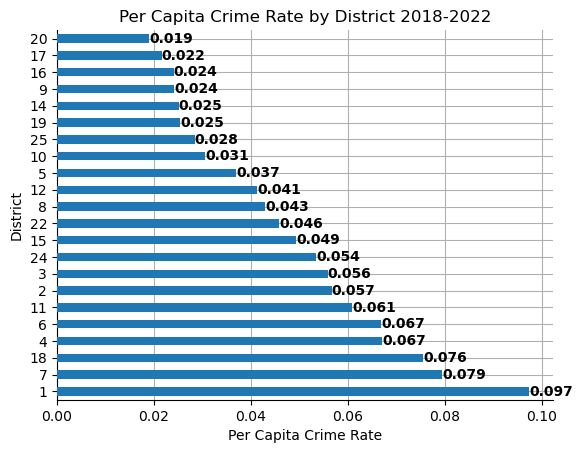

In [830]:
# Graph the per capita crime rate by district
plt.figure(figsize=(20, 20))
ax = district_per_capita.plot.barh(x = "District", y = "Per Capita Crime Rate", legend = False, zorder = 3)

# Set the x and y labels and title
plt.xlabel("Per Capita Crime Rate")
plt.ylabel("District")
plt.title("Per Capita Crime Rate by District 2018-2022")

# Add per capita crime rate values to each bar
for i, v in enumerate(district_per_capita["Per Capita Crime Rate"]):
    ax.text(v, i, f"{v:.3f}", color = "black", ha = "left", va = "center", weight = "bold")

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid
plt.grid(True)

# Save the figure
plt.savefig("Images/PerCapitaCrimeRatebyDistrict.png")

# Display the plot
plt.show()

In [831]:
# Look at per capita crime rate by primary type of crime over the five year timespan

# Remove "NON-CRIMINAL (SUBJECT SPECIFIED)" primary type as it contains an extremely small number of data points that we don't want to use
# in visualizations
final_df = final_df[final_df['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)']

# Get the population per primary type by removing duplicates
unique_type_pop = final_df[["Primary Type", "Zipcode", "Population"]].drop_duplicates()

# Get the total population by primary type by grouping by primary type then summing the population
pop_per_type = unique_type_pop.groupby("Primary Type")["Population"].sum()

# Get the crime count for each primary type by grouping and counting by primary type
cnt_per_type = district_df.groupby("Primary Type")["Primary Type"].count()

# Get the per capita crime count by dividing the count of crime type by population per crime type
per_cap_crime_type = cnt_per_type/pop_per_type

# Put in a data frame for easy use
type_per_capita = pd.DataFrame({"Primary Type" : per_cap_crime_type.index, "Per Capita Crime Rate" : per_cap_crime_type.values})

# Sort values in the data frame for easy graphing and reference
type_per_capita.sort_values(by = "Per Capita Crime Rate", ascending = False, inplace = True)
type_per_capita

,Primary Type,Per Capita Crime Rate
10,THEFT (ALL TYPES),0.043681
1,ASSAULT & BATTERY,0.029118
5,MINOR PROPERTY CRIME,0.014018
8,OTHER MINOR CRIMES,0.007878
2,DRUG RELATED,0.003952
11,WEAPONS RELATED CRIME,0.003520
9,SEXUAL RELATED CRIME,0.001138
7,OFFENSE INVOLVING CHILDREN,0.000907
3,HOMICIDE,0.000338
0,ARSON,0.000218


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


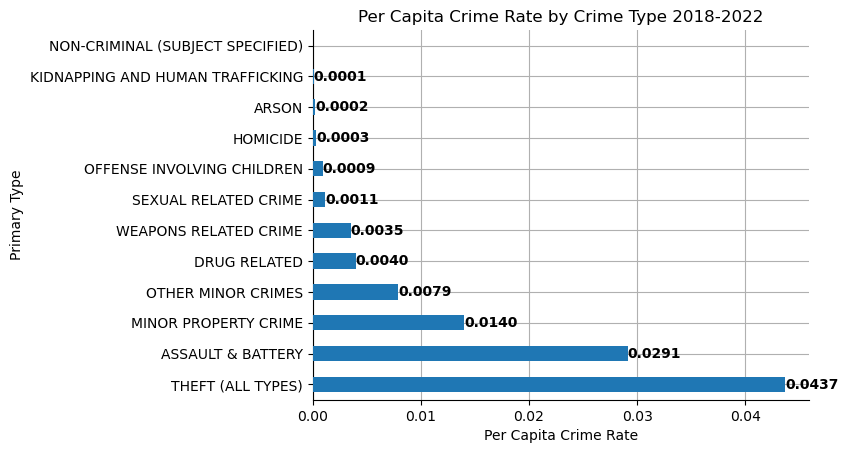

In [832]:
# Graph the results of the type of crime per capita
ax = type_per_capita.plot.barh(x = "Primary Type", y = "Per Capita Crime Rate", legend = False, zorder = 3)

# Set labels and title
plt.xlabel("Per Capita Crime Rate")
plt.ylabel("Primary Type")
plt.title("Per Capita Crime Rate by Crime Type 2018-2022")

# Add per capita crime rate values to each bar
for i, v in enumerate(type_per_capita["Per Capita Crime Rate"]):
    ax.text(v, i, f"{v:.4f}", color = "black", ha = "left", va = "center", weight = "bold")

# Remove the top and right borders
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a grid
plt.grid(True)

# Save figure
plt.savefig("Images/PerCapitaCrimeRatebyCrimeType.png")

# Display the plot
plt.show()

## Analyze Data Per Capita Per 1,000 People

In [833]:
# Look at types of crime per capita per 1,000 people  on the year level
# Count total crimes by crime type per year
year_crime_cnt = final_df.groupby("Year")["Primary Type"].count()

# Get the population for each year
pop_per_year = population

# Calculate per capita rate per 1,000 residents in Chicago
per_capita_crime_rate_1000 = year_crime_cnt/pop_per_year*1000

# Put it in a dataframe
yearly_per_capita_1000 = pd.DataFrame({"Year" : per_capita_crime_rate_1000.index, 
                                       "Number of Crimes per Year" : year_crime_cnt, 
                                       "Per Capita Crime Rate (per 1,000 People)" : per_capita_crime_rate_1000.values})
yearly_per_capita_1000 = yearly_per_capita_1000.reset_index(drop = True)
yearly_per_capita_1000

,Year,Number of Crimes per Year,"Per Capita Crime Rate (per 1,000 People)"
0,2018,258963,86.560426
1,2019,254518,84.422063
2,2020,204271,68.019027
3,2021,199060,66.140823
4,2022,228855,76.040681


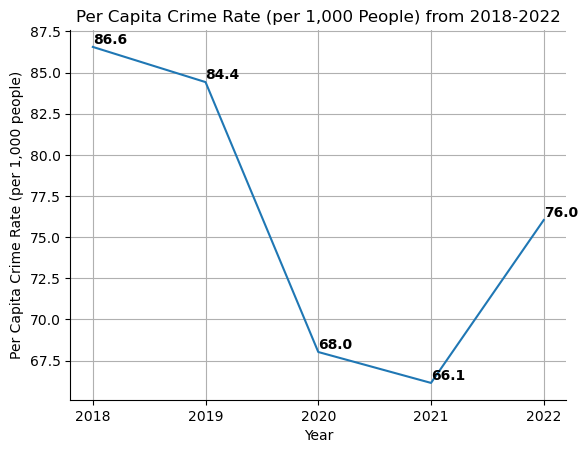

In [834]:
# Graph per capita crime rates over the 5 years per 1,000 residents in Chicago
plt.plot(yearly_per_capita_1000["Year"], yearly_per_capita_1000["Per Capita Crime Rate (per 1,000 People)"])

# Add labels
plt.xlabel("Year")
plt.ylabel("Per Capita Crime Rate (per 1,000 people)")
plt.title("Per Capita Crime Rate (per 1,000 People) from 2018-2022")

# Add values to the line chart
for x, y in zip(yearly_per_capita_1000["Year"], yearly_per_capita_1000["Per Capita Crime Rate (per 1,000 People)"]):
    plt.text(x, y, f"{y:.1f}", ha="left", va="bottom", weight = "bold")

# Create new x-ticks
new_xticks = years
plt.xticks(new_xticks)

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid
plt.grid(True)

## Save the figure
plt.savefig("Images/PerCapitaCrimeRate2018_2022(per1000people).png")
plt.show()


In [835]:
# Look at per capita crime rate per district over the five year timespan
# Grab selected columns we want to look at
district_df = final_df[["Year", "District", "Primary Type", "Population", "Zipcode"]]
district_df

# Get the population per district by creating a new data frame and dropping any unique combinations of distict, zip code, and population,
# since population will be duplicated multiple times when zip code is listed more than once
unique_pop_1000 = district_df[["District", "Zipcode", "Population"]].drop_duplicates()
pop_per_district_1000 = unique_pop_1000.groupby("District")["Population"].sum()

# Get the count per district by grouping by district and counting primary type of crime
cnt_per_district_1000 = district_df.groupby("District")["Primary Type"].count()
cnt_per_district_1000
# Get the per capita crime rate by dividing the count per district by the population per district
per_cap_crime_count_1000 = cnt_per_district_1000/pop_per_district_1000 * 1000

# Put in a data frame for ease of use
district_per_capita_1000 = pd.DataFrame({"District" : per_cap_crime_count_1000.index, "Per Capita Crime Rate (per 1,000 People)" : per_cap_crime_count_1000.values})

# Sort the values
district_per_capita_1000.sort_values(by = "Per Capita Crime Rate (per 1,000 People)", ascending = False, inplace=True)
district_per_capita_1000

,District,"Per Capita Crime Rate (per 1,000 People)"
0,1,97.490396
6,7,79.481077
16,18,75.588821
3,4,67.163206
5,6,66.931935
10,11,60.916045
1,2,56.674648
2,3,55.895755
20,24,53.523261
13,15,49.418634


<Figure size 2000x2000 with 0 Axes>

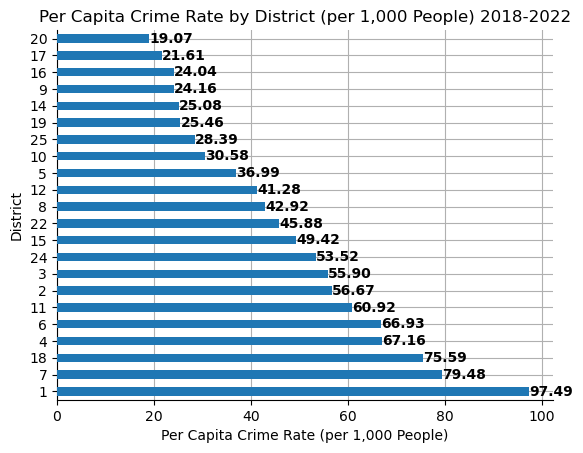

In [836]:
# Graph the per capita crime rate by district per 1,000 people
per_cap_by_dist = plt.figure(figsize=(20, 20))
ax = district_per_capita_1000.plot.barh(x = "District", y = "Per Capita Crime Rate (per 1,000 People)", legend = False, zorder = 3)

# Set axis below bars
ax.set_axisbelow(True)

# Set the x and y labels and title
plt.xlabel("Per Capita Crime Rate (per 1,000 People)")
plt.ylabel("District")
plt.title("Per Capita Crime Rate by District (per 1,000 People) 2018-2022")

# Add per capita crime rate values to each bar
for i, v in enumerate(district_per_capita_1000["Per Capita Crime Rate (per 1,000 People)"]):
    ax.text(v, i, f"{v:.2f}", color = "black", ha = "left", va = "center", weight = "bold")

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid
plt.grid(True)

# Save the figure
plt.savefig("Images/PerCapitaCrimeRatebyDistrictper1000People.png")

# Display the plot
plt.show()

In [837]:
# Look at per capita crime rate per district over the five year timespan per 1,000 residents
# Grab the columns we need from district_df
district_df = final_df[["Year", "District", "Primary Type", "Population", "Zipcode"]]
district_df

# Get the population per district by creating a new data frame and dropping any unique combinations of distict, zip code, and population,
# since zip code was used to pull population
unique_pop = district_df[["District", "Zipcode", "Population"]].drop_duplicates()
pop_per_district = unique_pop.groupby("District")["Population"].sum()

# Get the per capita crime count by grouping by District and counting primary type of crime
cnt_per_district = district_df.groupby("District")["Primary Type"].count()
cnt_per_district

# Get the per capita crime count per 1,000 residents
per_cap_crime_cnt_1000 = cnt_per_district/pop_per_district*1000

# Put in a data frame for ease of use
district_per_capita_1000 = pd.DataFrame({"District" : per_cap_crime_cnt_1000.index, 
                                         "Population per District" : pop_per_district, 
                                         "Total Number of Crimes" : cnt_per_district, 
                                         "Per Capita Crime Rate (per 1,000 People) per District" : per_cap_crime_cnt_1000.values})
district_per_capita_1000.sort_values(by = "Per Capita Crime Rate (per 1,000 People) per District", ascending = False, inplace=True)
district_per_capita_1000 = district_per_capita_1000.reset_index(drop = True)
district_per_capita_1000

,District,Population per District,Total Number of Crimes,"Per Capita Crime Rate (per 1,000 People) per District"
0,1,612009.0,59665,97.490396
1,7,754255.0,59949,79.481077
2,18,807249.0,61019,75.588821
3,4,950580.0,63844,67.163206
4,6,1116104.0,74703,66.931935
5,11,1280221.0,77986,60.916045
6,2,930963.0,52762,56.674648
7,3,1025051.0,57296,55.895755
8,24,690298.0,36947,53.523261
9,15,799152.0,39493,49.418634


In [838]:
# Look at per capita crime rate by primary type of crime over the five year timespan per 1,000 people

# Remove "NON-CRIMINAL (SUBJECT SPECIFIED)" primary type as it contains an extremely small number of data points that we don't want to use
# in visualizations
final_df = final_df[final_df['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)']

# Get the population per primary type by removing duplicates
unique_type_pop_1000 = final_df[["Primary Type", "Zipcode", "Population"]].drop_duplicates()

# Get the total population by primary type by grouping by primary type then summing the population
pop_per_type_1000 = unique_type_pop_1000.groupby("Primary Type")["Population"].sum()

# Get the crime count for each primary type by grouping and counting by primary type
cnt_per_type_1000 = district_df.groupby("Primary Type")["Primary Type"].count()

# Get the per capita crime count by dividing the count of crime type by population per crime type
per_cap_crime_type_1000 = cnt_per_type_1000/pop_per_type_1000*1000

# Put in a data frame for easy use
type_per_capita_1000 = pd.DataFrame({"Primary Type" : per_cap_crime_type_1000.index, "Per Capita Crime Rate (per 1,000 People)" : per_cap_crime_type_1000.values})

# Sort values in the data frame for easy graphing and reference
type_per_capita_1000.sort_values(by = "Per Capita Crime Rate (per 1,000 People)", ascending = False, inplace = True)
type_per_capita_1000

,Primary Type,"Per Capita Crime Rate (per 1,000 People)"
9,THEFT (ALL TYPES),43.681153
1,ASSAULT & BATTERY,29.117601
5,MINOR PROPERTY CRIME,14.018467
7,OTHER MINOR CRIMES,7.877502
2,DRUG RELATED,3.952058
10,WEAPONS RELATED CRIME,3.519974
8,SEXUAL RELATED CRIME,1.138044
6,OFFENSE INVOLVING CHILDREN,0.907341
3,HOMICIDE,0.337906
0,ARSON,0.217733


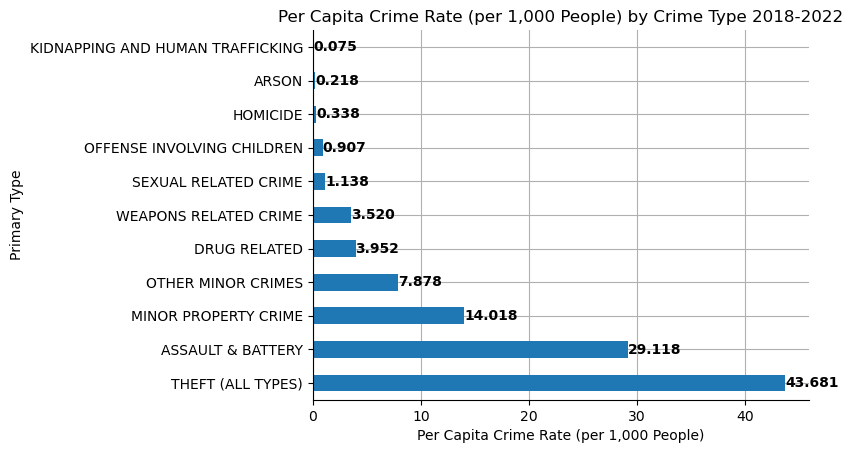

In [839]:
# Graph the results of the type of crime per capita
ax = type_per_capita_1000.plot.barh(x = "Primary Type", y = "Per Capita Crime Rate (per 1,000 People)", legend = False)

# Set axis below bars
ax.set_axisbelow(True)

# Set labels and title
plt.xlabel("Per Capita Crime Rate (per 1,000 People)")
plt.ylabel("Primary Type")
plt.title("Per Capita Crime Rate (per 1,000 People) by Crime Type 2018-2022")

# Add per capita crime rate values to each bar
for i, v in enumerate(type_per_capita_1000["Per Capita Crime Rate (per 1,000 People)"]):
    ax.text(v, i, f"{v:.3f}", color = "black", ha = "left", va = "center", weight = "bold")

# Remove the top and right borders
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a grid
plt.grid(True)

# Save figure
plt.savefig("Images/PerCapitaCrimeRatebyCrimeType1000.png")

# Display the plot
plt.show()

## Create Pie Chart Visualizations

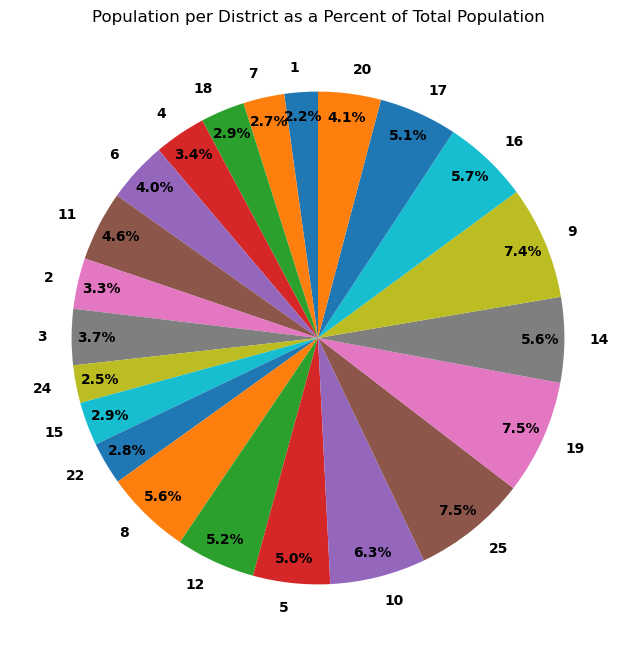

In [840]:
# Make a pie chart of population per district compared to total population
# Calculate the total population
total_population = district_per_capita_1000["Population per District"].sum()

# Calculate the percentage of population per district
district_per_capita_1000["Population Percentage"] = (district_per_capita_1000["Population per District"] / total_population * 100)

# Create the pie plot
plt.figure(figsize=(8, 8))
patches, labels, percentages = plt.pie(
    district_per_capita_1000["Population Percentage"],
    labels=district_per_capita_1000["District"],
    autopct="%1.1f%%",
    startangle=90,
    # Adjust the distance of the percentages from the center
    pctdistance=0.90,  
    # Adjust text properties
    textprops={"fontsize": 10, "color": "black", "weight": "bold"}  
)

# Add a title
plt.title("Population per District as a Percent of Total Population")

# Save the figure
plt.savefig("Images/PopulationasaPercentofTotalPop.png")

# Display the plot
plt.show()

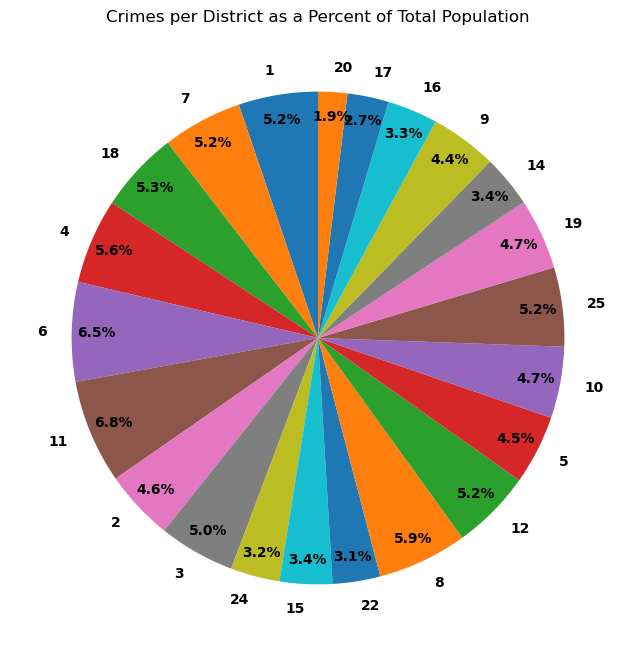

In [841]:
# Make a pie chart of population per district compared to total number of crimes
# Calculate the total population
total_population = district_per_capita_1000["Total Number of Crimes"].sum()

# Calculate the percentage of population per district
district_per_capita_1000["Total Number of Crimes"] = (district_per_capita_1000["Total Number of Crimes"] / total_population * 100)

# Create the pie plot
plt.figure(figsize=(8, 8))
patches, labels, percentages = plt.pie(
    district_per_capita_1000["Total Number of Crimes"],
    labels=district_per_capita_1000["District"],
    autopct="%1.1f%%",
    startangle=90,
    # Adjust the distance of the percentages from the center
    pctdistance=0.90,  
    # Adjust text properties
    textprops={"fontsize": 10, "color": "black", "weight": "bold"}  
)

# Add a title
plt.title("Crimes per District as a Percent of Total Population")

# Save the figure
plt.savefig("Images/PopulationasaPercentofTotalPop.png")

# Display the plot
plt.show()

## Look at Statistics of Per Capita Crime Rate per 1,000 People

In [842]:
# Get the per_capita_crime_rates per 1,000 people
per_capita_crime_rates = district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"]

# Calculate summary statistics to see how the districts vary from the mean and median
summary_stats = per_capita_crime_rates.describe()
print(summary_stats)

count    22.000000
mean     46.751993
std      21.628849
min      19.074051
25%      26.190995
50%      44.404731
75%      59.855696
max      97.490396
Name: Per Capita Crime Rate (per 1,000 People) per District, dtype: float64


In [843]:
# Find the percent difference between the highest and lowest per capita rate (per 1,000 people) for all districts
highest_rate = district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"].max()
lowest_rate = district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"].min()
difference = (highest_rate - lowest_rate)
percent_difference = (highest_rate - lowest_rate) / ((highest_rate + lowest_rate)/2) * 100
percent_difference

134.54590549165727

## Create other visualizations including maps and summary statistics

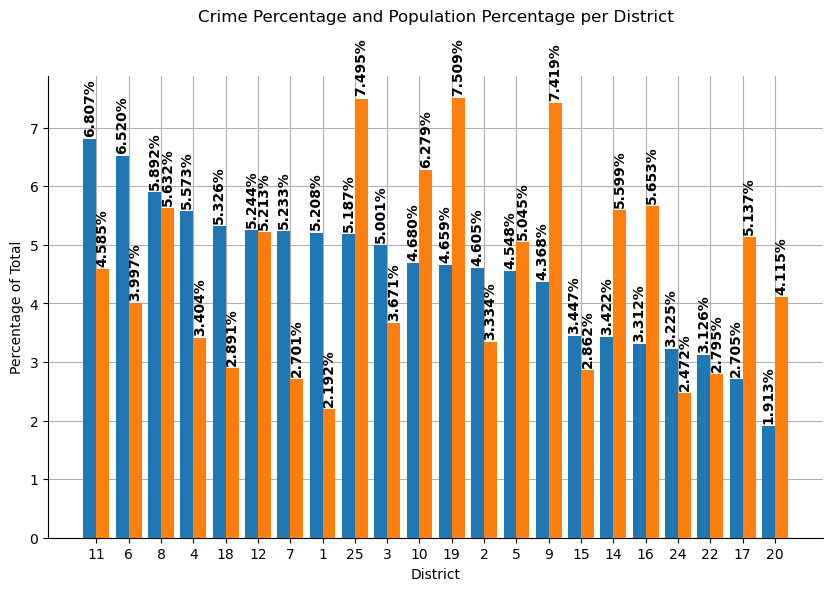

In [844]:
# Plot a bar chart showing the percentage of crime and population per total
# Calculate the percentage of crime per total crime count for all districts
crime_percentage = cnt_per_district / cnt_per_district.sum() * 100

# Calculate the percentage of population per total population for all districts
population_percentage = pop_per_district / pop_per_district.sum() * 100

# Sort the data in descending order
crime_percentage_sorted = crime_percentage.sort_values(ascending=False)
population_percentage_sorted = population_percentage.loc[crime_percentage_sorted.index]

# Set the bar width
bar_width = 0.4

# Set the x positions of the bars
x = np.arange(len(crime_percentage_sorted))

# Plot the bars for crime percentage
plt.figure(figsize=(10, 6))
plt.bar(x, crime_percentage_sorted, width = bar_width, label = "Crime Percentage", zorder = 3)

# Plot the bars for population percentage
plt.bar(x + bar_width, population_percentage_sorted, width = bar_width, label = "Population Percentage", zorder = 3)

# Set the labels and title
plt.xlabel("District")
plt.ylabel("Percentage of Total")
plt.title("Crime Percentage and Population Percentage per District", y = 1.1)

# Add grid
plt.grid(True)

# Add labels on top of the bars with rotated percentages
for i, v in enumerate(crime_percentage_sorted):
    plt.text(i, v + 0.1, f'{v:.3f}%', ha=  "center", rotation=90, weight = "bold")

for i, v in enumerate(population_percentage_sorted):
    plt.text(i + bar_width, v + 0.1, f'{v:.3f}%', ha = "center", rotation=90, weight = "bold")

# Set the x-axis tick positions and labels
plt.xticks(x + bar_width / 2, crime_percentage_sorted.index)

# Remove the top and right borders
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

## Save the figure
plt.savefig("Images/PopulationandCrimeasaPercentofTotal.png")

# Display the plot
plt.show()

In [845]:
# Create a DataFrame with summary statistics using the above created values
crime_pop_summary = pd.DataFrame({
    "District": crime_percentage_sorted.index,
    "Crime %": crime_percentage_sorted.values,
    "Population %": population_percentage_sorted.values,
    "Per Capita Crime Rate (per 1,000 People) per District" : district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"],
    "Mean" : summary_stats["mean"],
    "Difference Between per Capita Rate and Mean" : district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"] - summary_stats["mean"]
})

# Reset the index and sort the table
crime_pop_summary = crime_pop_summary.reset_index(drop = True)
crime_pop_summary = crime_pop_summary.sort_values(by = "Crime %", ascending = False)

# Save DataFrame as .png
crime_pop_summary.dfi.export("SummaryTable.png")
crime_pop_summary

,District,Crime %,Population %,"Per Capita Crime Rate (per 1,000 People) per District",Mean,Difference Between per Capita Rate and Mean
0,11,6.807039,4.584934,97.490396,46.751993,50.738404
1,6,6.520481,3.997172,79.481077,46.751993,32.729085
2,8,5.891677,5.631680,75.588821,46.751993,28.836828
3,4,5.572649,3.404371,67.163206,46.751993,20.411213
4,18,5.326068,2.891050,66.931935,46.751993,20.179942
5,12,5.244456,5.213338,60.916045,46.751993,14.164052
6,7,5.232672,2.701260,56.674648,46.751993,9.922655
7,1,5.207883,2.191825,55.895755,46.751993,9.143763
8,25,5.186673,7.495127,53.523261,46.751993,6.771268
9,3,5.001104,3.671078,49.418634,46.751993,2.666641


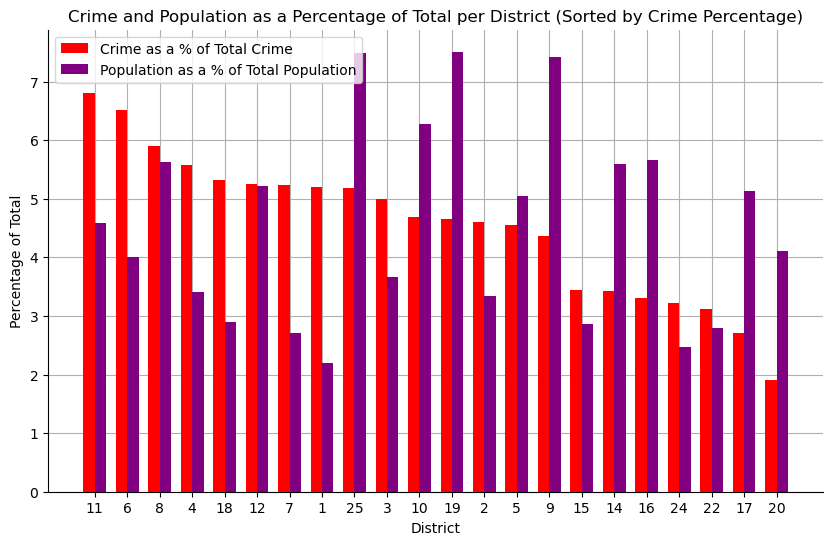

In [846]:
# Recreate the graph above with better colors and labels
# Calculate the percentage of crime per total crime count for all districts
crime_percentage = cnt_per_district / cnt_per_district.sum() * 100

# Calculate the percentage of population per total population for all districts
population_percentage = pop_per_district / pop_per_district.sum() * 100

# Sort the data in descending order
crime_percentage_sorted = crime_percentage.sort_values(ascending=False)

# Set the bar width
bar_width = 0.35

# Set the x positions of the bars
x = np.arange(len(crime_percentage_sorted))

# Plot the bars for crime percentage
plt.figure(figsize=(10, 6))
plt.bar(x, crime_percentage_sorted, width = bar_width, label = "Crime Percentage as a Percent of Total Crime", color = "red", zorder = 3)

# Plot the bars for population percentage
plt.bar(x + bar_width, population_percentage_sorted, width = bar_width, label = "Population Percentage as a Percent of Total Population", color = "purple", zorder = 3)

# Add a grid
plt.grid(True, zorder = 0)

# Set the labels and title
plt.xlabel("District")
plt.ylabel("Percentage of Total")
plt.title("Crime and Population as a Percentage of Total per District (Sorted by Crime Percentage)")

# Set the x-axis tick positions and labels
plt.xticks(x + bar_width / 2, crime_percentage_sorted.index)

# Remove the top and right borders
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add a legend
plt.legend(["Crime as a % of Total Crime", "Population as a % of Total Population"], loc = "upper left")

## Save the figure
plt.savefig("Images/PopulationandCrimeasaPercentofTotalFinal.png")

# Display the plot
plt.show()

In [847]:
# Create a map that plots all crimes on a map with the color of the marker changing based on the number of crimes per district

# Group by district, and take the mean latitude and longitude to get the center of the district on the map, and count the number of 
# primary types of crimes in each district
grouped = final_df.groupby("District").agg(
    Latitude=("Latitude", "mean"),
    Longitude=("Longitude", "mean"),
    num_crimes=("Primary Type", "size"),
    # Pick one district number per population group
    district_name=("District", lambda x: x.unique()[0])
).reset_index()

# Configure the map plot
city_map = grouped.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    frame_width = 800,
    frame_height = 600,
    hover = True,
    size = 1500,
    ylabel = "Latitude",
    xlabel = "Longitude",
    color = "num_crimes",
    tiles = "OSM",
    alpha = .75,
    hover_cols = ["district_name"],
    clabel = "Number of Crimes"
) 

# Display the map
city_map



:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (num_crimes,district_name)

In [848]:
# Create a map that plots all crimes on a mapon a map with the size of the marker changing based on the number of crimes per district, as well
# as the color of the marker changing by number of crimes per district

# Group by district, and take the mean latitude and longitude to get the center of the district on the map, and count the number of 
# primary types of crimes in each district
# Aggregate the data
grouped = final_df.groupby("District").agg({"Latitude" : "mean", "Longitude" : "mean", "Primary Type" : "size"}).reset_index()
# Rename Primary Type to number_crimes for clarity
grouped = grouped.rename(columns = {"Primary Type" : "number_crimes"})

# Scale the number of crimes per district down for the map to appear more legible, but keep the proportionality of the crime rates 
# per district the same.  These scaled values will be between 0 and 1, by using the max-scaling method.
# Pick a scaling factor that will make the markers appear an appropriate size on the map
scaling_factor = 1000

# Take the max size of each of the district's number of crimes
max_size = grouped["number_crimes"].max()

# Create a new column, scaled_size, by dividing each number of crimes data by max size, then multiply it by the scaling factor
grouped["scaled_size"] = grouped["number_crimes"] / max_size * scaling_factor

# Configure the map plot
city_map = grouped.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    frame_width = 800,
    frame_height = 600,
    hover = True,
    size = "scaled_size",
    ylabel = "Latitude",
    xlabel = "Longitude",
    color = "number_crimes",
    tiles = "OSM",
    alpha = .85,
    hover_col = ["District"],
    legend = "right"
)

# Display the map
city_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (number_crimes,scaled_size)